## Exploratory Data Analysis of our imputed mushroom dataset
* Run Cramers V to get an indication of dependency of columns with target column
* Make some graphs to get a better idea of dataset



In [24]:
# import packages

import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import klib
import plotly.figure_factory as ff
from IPython.core.display import display
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import joblib
# pd.set_option('display.max_columns', None)
# pd.reset_option('max_rows')
#np.set_printoptions(threshold=sys.maxsize)

plt.style.use('dark_background')
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})
sns.set(style='ticks', context='talk')

In [25]:
# useful functions
def get_adjusted_cramers_v(contingency_table):
    """ variation of cramers v that adjusts for bias
    via using a smaller mean-squared error.
    It calculates and returns this statistic"""

    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    number_of_obs = np.sum(contingency_table).sum()
    phi2 = chi2 / number_of_obs
    phi2_adjusted = max(0, phi2 - dof/(number_of_obs-1))
    row, column = contingency_table.shape
    row_adjusted = row - ((row-1)**2)/(number_of_obs-1)
    column_adjusted = column - ((column-1)**2)/(number_of_obs-1)
    mini_adjusted = min(row_adjusted, column_adjusted)-1

    cramers_v_adjusted = np.sqrt(phi2_adjusted / mini_adjusted)
    return cramers_v_adjusted


In [26]:
path = r'../../data/processed/mushroom_imputed_2.csv'

mushroom = pd.read_csv(path)
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,bruises,pungent,free,close,narrow,black,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,bruises,almond,free,close,broad,black,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,bruises,anise,free,close,broad,brown,...,smooth,smooth,white,white,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,bruises,pungent,free,close,narrow,brown,...,smooth,smooth,white,white,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,no,none,free,crowded,broad,black,...,smooth,smooth,white,white,white,one,evanescent,brown,abundant,grasses


In [27]:
mushroom.shape, mushroom.isnull().sum()

((8112, 22),
 class                       0
 cap-shape                   0
 cap-surface                 0
 cap-color                   0
 bruises                     0
 odor                        0
 gill-attachment             0
 gill-spacing                0
 gill-size                   0
 gill-color                  0
 stalk-shape                 0
 stalk-root                  0
 stalk-surface-above-ring    0
 stalk-surface-below-ring    0
 stalk-color-above-ring      0
 stalk-color-below-ring      0
 veil-color                  0
 ring-number                 0
 ring-type                   0
 spore-print-color           0
 population                  0
 habitat                     0
 dtype: int64)

Quick check to see our size; and corrected that we have no missing values at all

Also want to capitalize all columns of the mushroom features

In [28]:
mush_col = mushroom.columns.tolist()
for count, col in enumerate(mush_col):
    mush_col[count] = mush_col[count].title()

mushroom.columns = mush_col
mushroom.columns

Index(['Class', 'Cap-Shape', 'Cap-Surface', 'Cap-Color', 'Bruises', 'Odor',
       'Gill-Attachment', 'Gill-Spacing', 'Gill-Size', 'Gill-Color',
       'Stalk-Shape', 'Stalk-Root', 'Stalk-Surface-Above-Ring',
       'Stalk-Surface-Below-Ring', 'Stalk-Color-Above-Ring',
       'Stalk-Color-Below-Ring', 'Veil-Color', 'Ring-Number', 'Ring-Type',
       'Spore-Print-Color', 'Population', 'Habitat'],
      dtype='object')

In [29]:
# save this adjusted column naming
path_csv = r'../../data/processed/mushroom_imputed_2_adj.csv'
mushroom.to_csv(path_csv)

In [30]:
mush_col = mushroom.drop('Class', axis=1).columns.tolist()

adj_cramers_v_values = []
for col in mush_col:
   contingency_table = pd.crosstab(mushroom['Class'], mushroom[col])
   adj_cramers_v_values.append(get_adjusted_cramers_v(contingency_table))

In [31]:
# get associated strengths for more interpretatbilitty
assoc_strengths = ['Strong', 'Moderate', 'Weak', 'Very weak']

assoc_strengths_values = [assoc_strengths[0] if val > 0.5 else
                          assoc_strengths[1] if val > 0.3 else
                          assoc_strengths[2] if val > 0.1 else
                          assoc_strengths[3] for val in adj_cramers_v_values]

In [32]:
relation_df = pd.DataFrame({'Mushroom Features':mush_col,
                            'Adjusted Cramers V':adj_cramers_v_values,
                            'Association Strength': assoc_strengths_values}).sort_values(by='Adjusted Cramers V', ascending=False)
relation_df.reset_index(drop=True, inplace=True)
relation_df

,Mushroom Features,Adjusted Cramers V,Association Strength
0,Odor,0.970520,Strong
1,Spore-Print-Color,0.753543,Strong
2,Gill-Color,0.680438,Strong
3,Ring-Type,0.602381,Strong
4,Stalk-Surface-Above-Ring,0.589013,Strong
5,Stalk-Surface-Below-Ring,0.575930,Strong
6,Gill-Size,0.539272,Strong
7,Stalk-Color-Above-Ring,0.523683,Strong
8,Stalk-Color-Below-Ring,0.513519,Strong
9,Bruises,0.503003,Strong


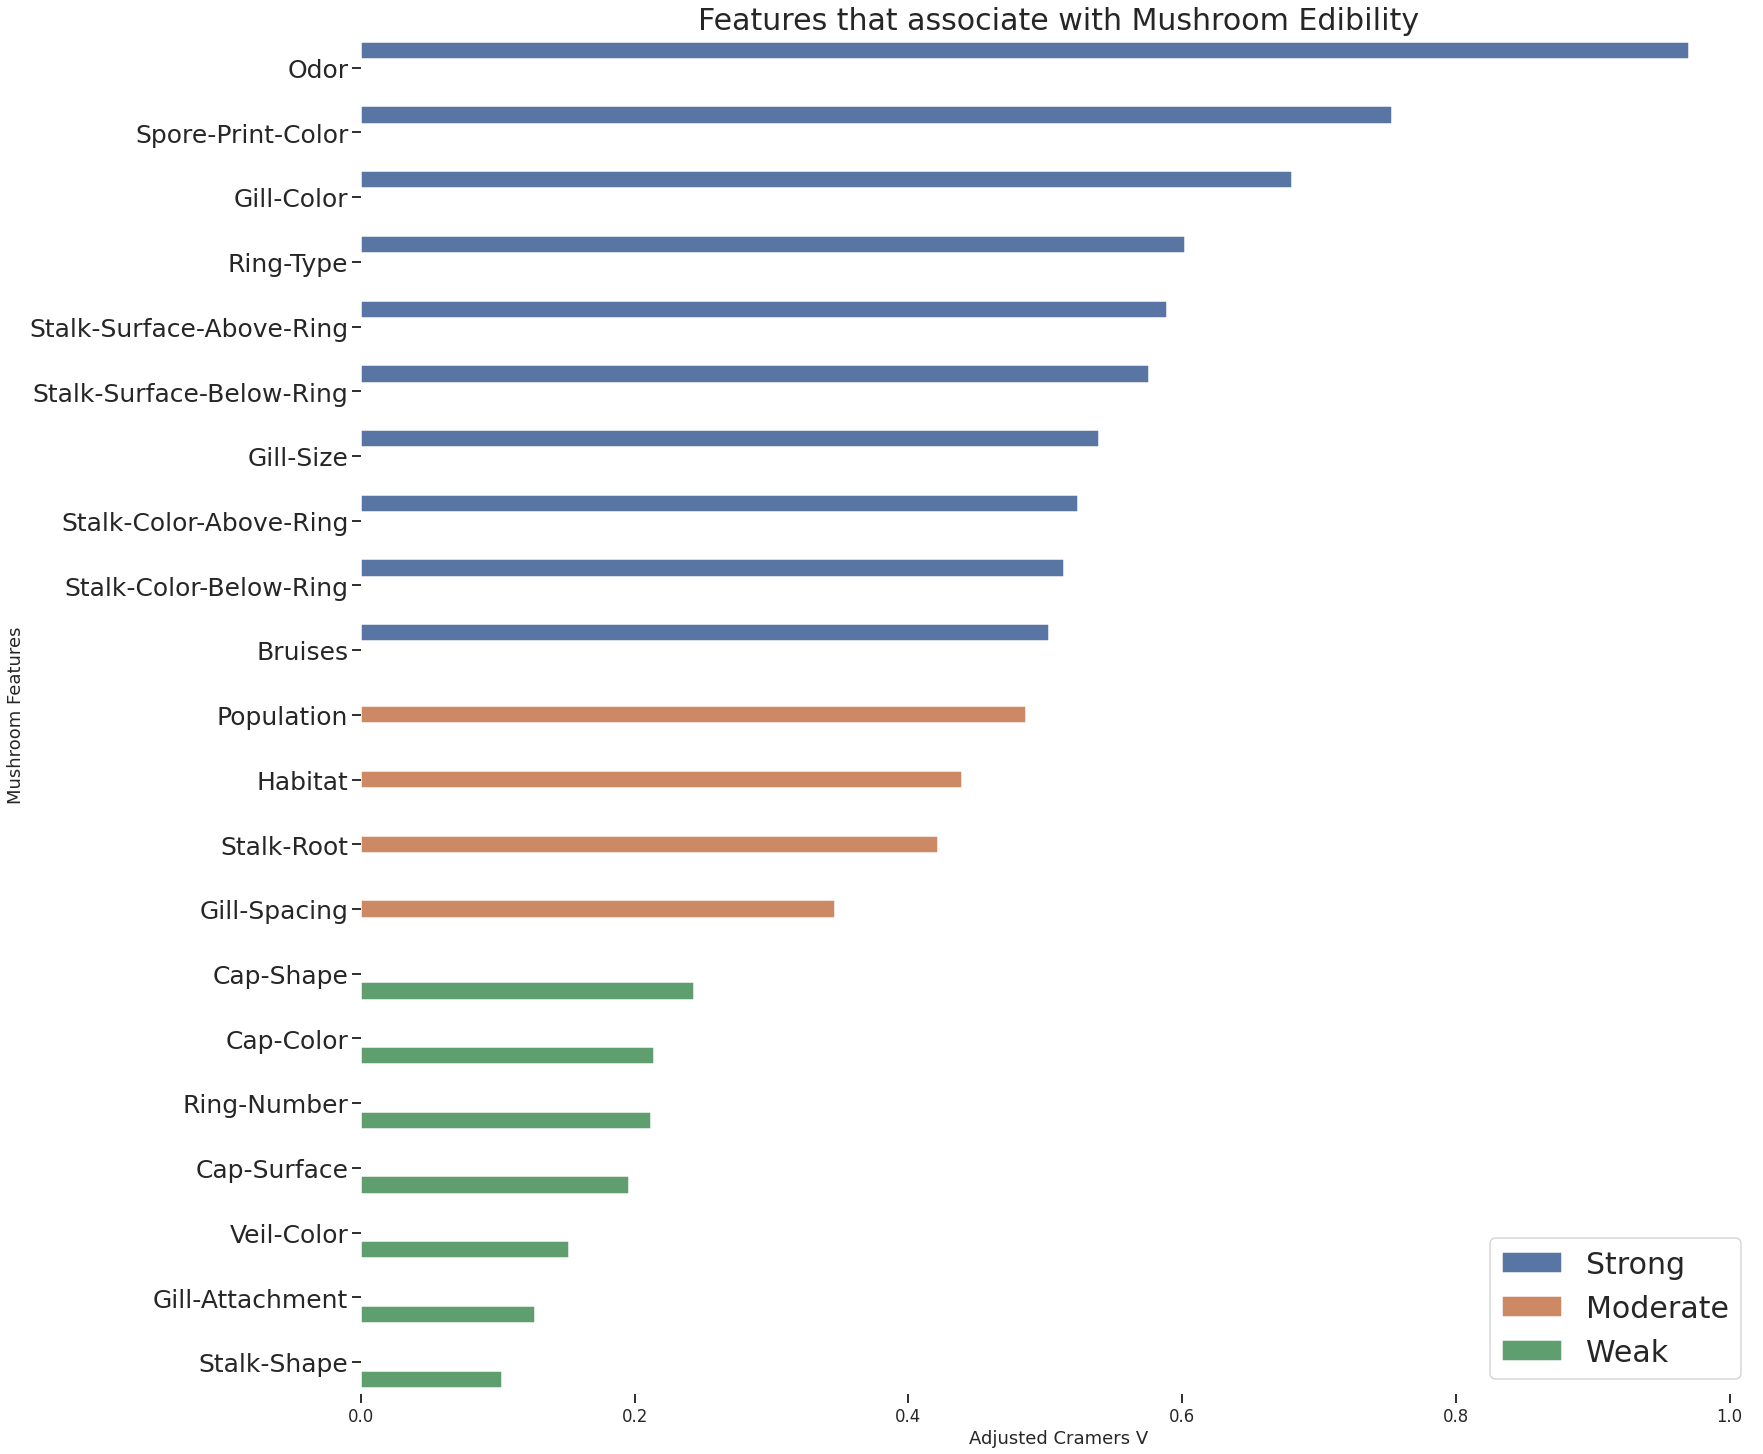

In [33]:
plt.figure(figsize=(25,25))
sns.barplot(data=relation_df, y='Mushroom Features', x='Adjusted Cramers V', hue='Association Strength')
sns.despine(left=True, bottom=True)
plt.title('Features that associate with Mushroom Edibility', fontsize=30)
plt.yticks(fontsize=25)
plt.legend(fontsize=30)

The strongest indicators for edibility of mushroom should be the
odor, spore-print color, gill color, ring type, gill size, bruising, and other stalk-color around the rings

Surprisingly habitat, veil color, cap color, and stalk shape were weak indicators for edibility

In [34]:
# look at the docs and draw more graphs
# also ask more questions about dataset
for col in mush_col:
    print(col, mushroom[col].unique())

Cap-Shape ['convex' 'bell' 'sunken' 'flat' 'knobbed' 'conical']
Cap-Surface ['smooth' 'scaly' 'fibrous' 'grooves']
Cap-Color ['brown' 'yellow' 'white' 'gray' 'red' 'pink' 'buff' 'cinnamon' 'purple'
 'green']
Bruises ['bruises' 'no']
Odor ['pungent' 'almond' 'anise' 'none' 'foul' 'creosote' 'musty' 'fishy'
 'spicy']
Gill-Attachment ['free' 'attached']
Gill-Spacing ['close' 'crowded']
Gill-Size ['narrow' 'broad']
Gill-Color ['black' 'brown' 'gray' 'pink' 'white' 'chocolate' 'purple' 'green'
 'yellow' 'red' 'buff' 'orange']
Stalk-Shape ['enlarging' 'tapering']
Stalk-Root ['equal' 'club' 'bulbous' 'rooted']
Stalk-Surface-Above-Ring ['smooth' 'fibrous' 'silky' 'scaly']
Stalk-Surface-Below-Ring ['smooth' 'fibrous' 'scaly' 'silky']
Stalk-Color-Above-Ring ['white' 'gray' 'pink' 'brown' 'buff' 'cinnamon' 'yellow' 'red' 'orange']
Stalk-Color-Below-Ring ['white' 'pink' 'gray' 'buff' 'brown' 'cinnamon' 'yellow' 'red' 'orange']
Veil-Color ['white' 'yellow' 'brown' 'orange']
Ring-Number ['one' 'two'

# Extra Visualizations
* count plots for poionsonouse and top cramers v features


Text(0.5, 1.0, "If no smell it's most likely edible")

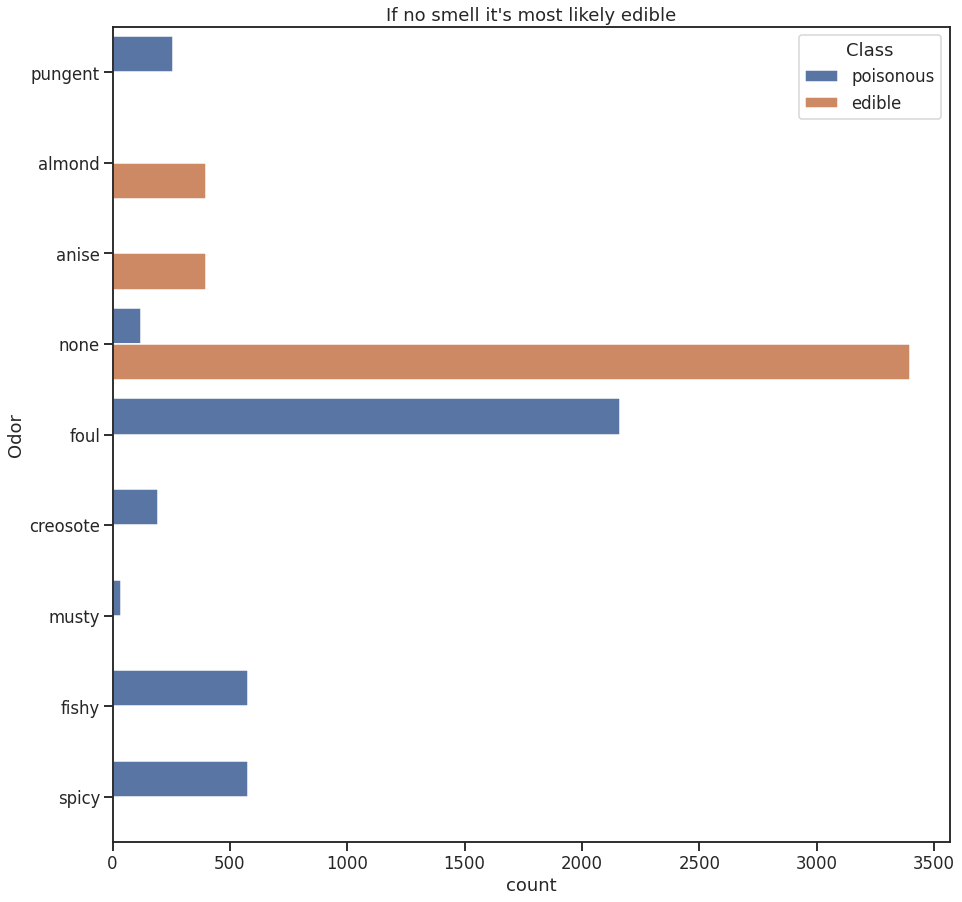

In [35]:
# do by odor
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Odor', hue='Class')
plt.title("If no smell it's most likely edible")

Basically this is saying that almond, anise, or have no odor, it is most likely edible
else other smells like spicy, fishy, musty, pungent, foul, creosote (smoky or like tar) means its poisonous

In [36]:
# see percentages
odor_edible = pd.crosstab(mushroom['Class'], mushroom['Odor'], normalize='columns')
odor_edible

Odor,almond,anise,creosote,fishy,foul,musty,none,pungent,spicy
Class,,,,,,,,,
edible,1.0,1.0,0.0,0.0,0.0,0.0,0.96587,0.0,0.0
poisonous,0.0,0.0,1.0,1.0,1.0,1.0,0.03413,1.0,1.0


* Data set does not tell much
* Mainly as we can see fromt he cross tab most of results are binary or show that mushrooms have no smell will  be edible
* If mushroom smells like something probably most likely poisonous
* We need an updated dataset for this
* Also little variation between the two classes

Text(0.5, 1.0, 'Beware Of Chocolate, White, Green (Spore Prints)')

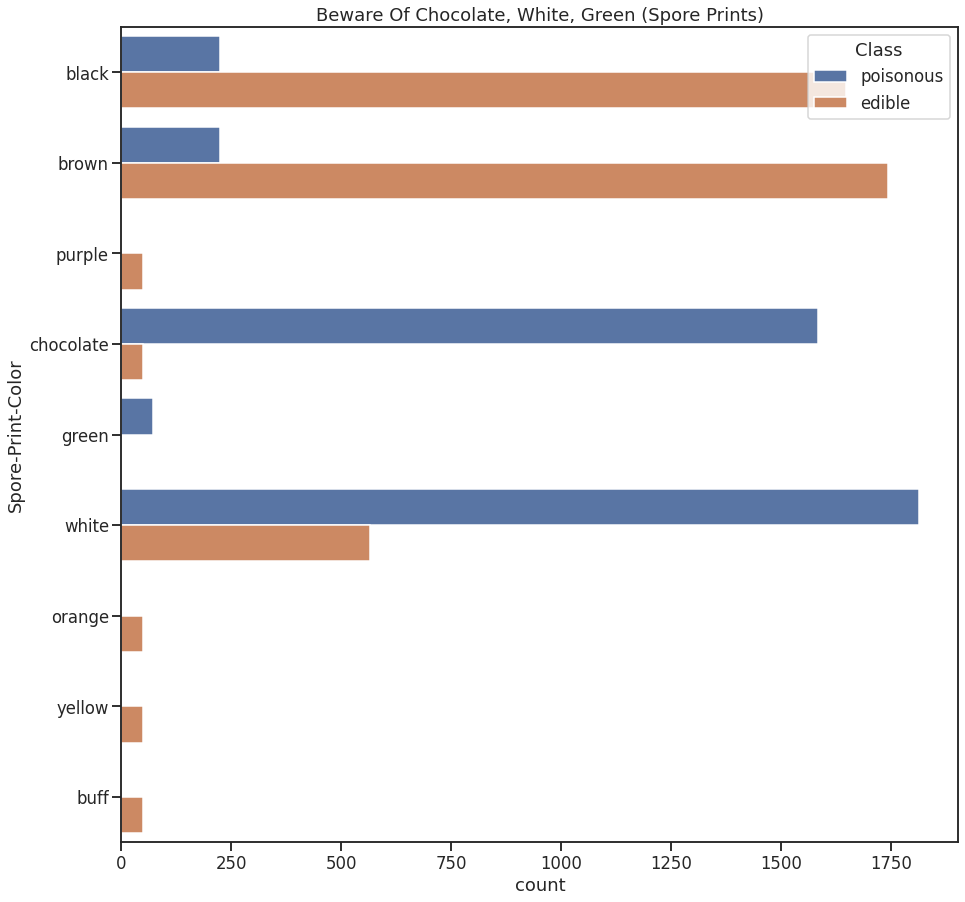

In [37]:

# do by spore print color
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Spore-Print-Color', hue='Class')
plt.title("Beware Of Chocolate, White, Green (Spore Prints)")

* Once again wish there was more variety among colors
* but this points that most black, brown, and purple prints seem fine
* Question what poison means in this case as purple color which is common in psychedlic mushrooms, but I guess they label those as not poisonous
* I wish this dataset also linked the mushroom as well

In [38]:
spore_color_edible = pd.crosstab(mushroom['Class'], mushroom['Spore-Print-Color'], margins=True, normalize='columns')
spore_color_edible

Spore-Print-Color,black,brown,buff,chocolate,green,orange,purple,white,yellow,All
Class,,,,,,,,,,
edible,0.880342,0.886063,1.0,0.029412,0.0,1.0,1.0,0.238015,1.0,0.517258
poisonous,0.119658,0.113937,0.0,0.970588,1.0,0.0,0.0,0.761985,0.0,0.482742


<AxesSubplot:xlabel='count', ylabel='Gill-Color'>

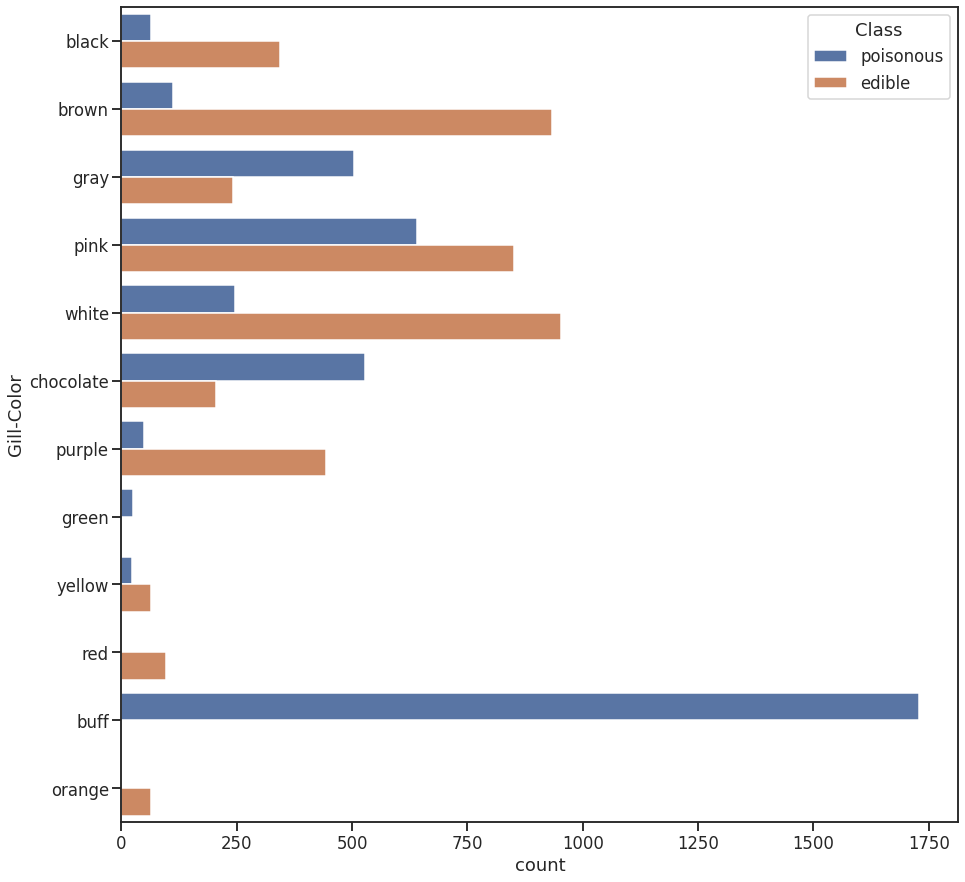

In [39]:
# see gill bruising stalk
# do by spore print color
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Gill-Color', hue='Class')
# plt.title("Beware Of Chocolate, White, Green (Spore Prints)")
# see habitat
# see viel cap color, shape, viel color

<AxesSubplot:xlabel='count', ylabel='Gill-Size'>

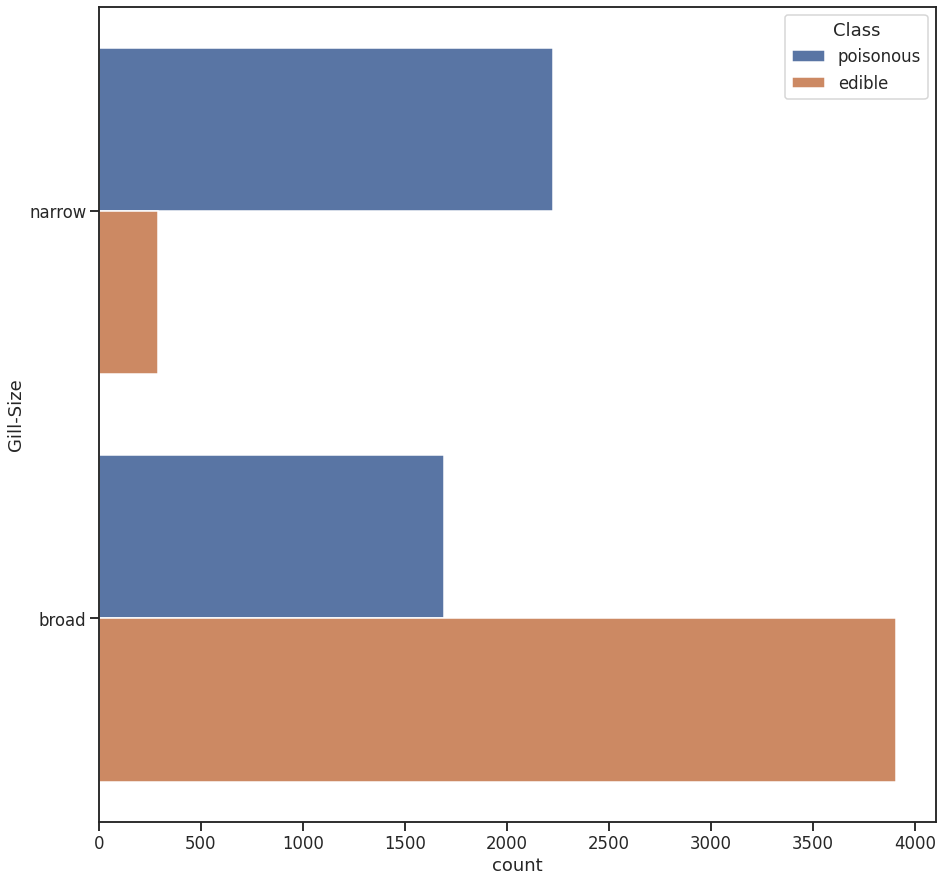

In [40]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Gill-Size', hue='Class')
# plt.title("Beware Of Chocolate, White, Green (Spore Prints)")

<AxesSubplot:xlabel='count', ylabel='Ring-Type'>

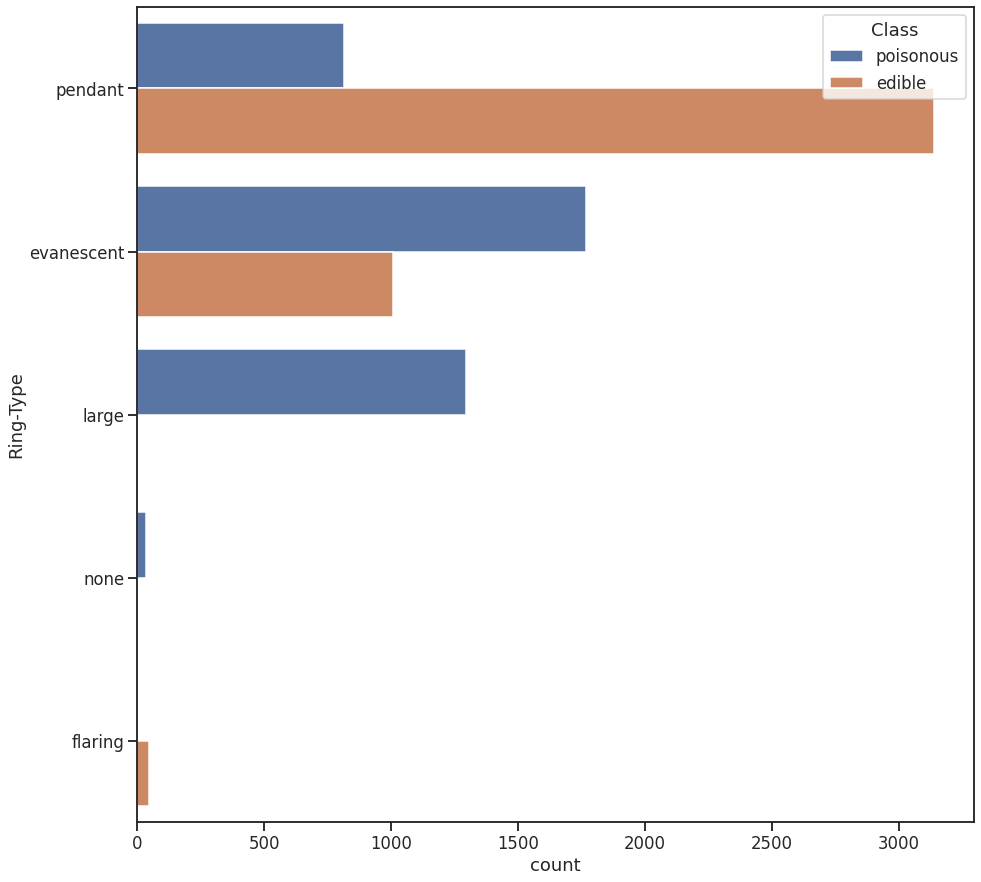

In [41]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Ring-Type', hue='Class')
# plt.title("Beware Of Chocolate, White, Green (Spore Prints)")

<AxesSubplot:xlabel='count', ylabel='Bruises'>

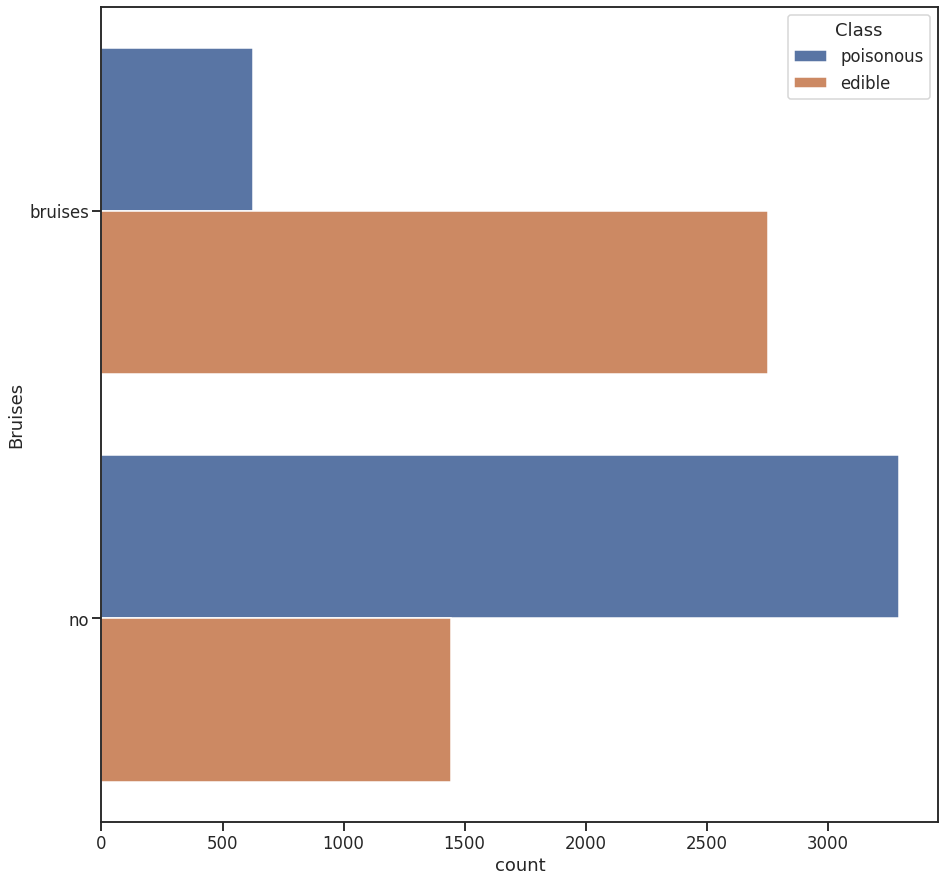

In [42]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Bruises', hue='Class')
# plt.title("Beware Of Chocolate, White, Green (Spore Prints)")

<AxesSubplot:xlabel='count', ylabel='Stalk-Surface-Above-Ring'>

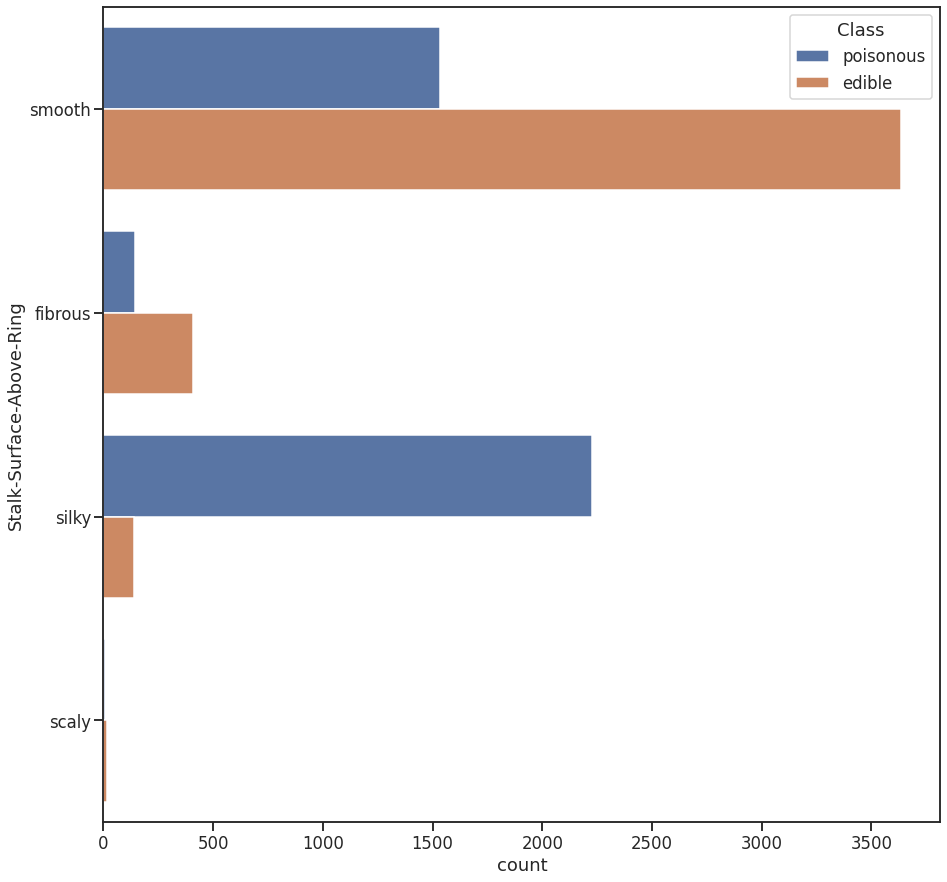

In [43]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Stalk-Surface-Above-Ring', hue='Class')
# plt.title("Beware Of Chocolate, White, Green (Spore Prints)")

<AxesSubplot:xlabel='count', ylabel='Stalk-Surface-Below-Ring'>

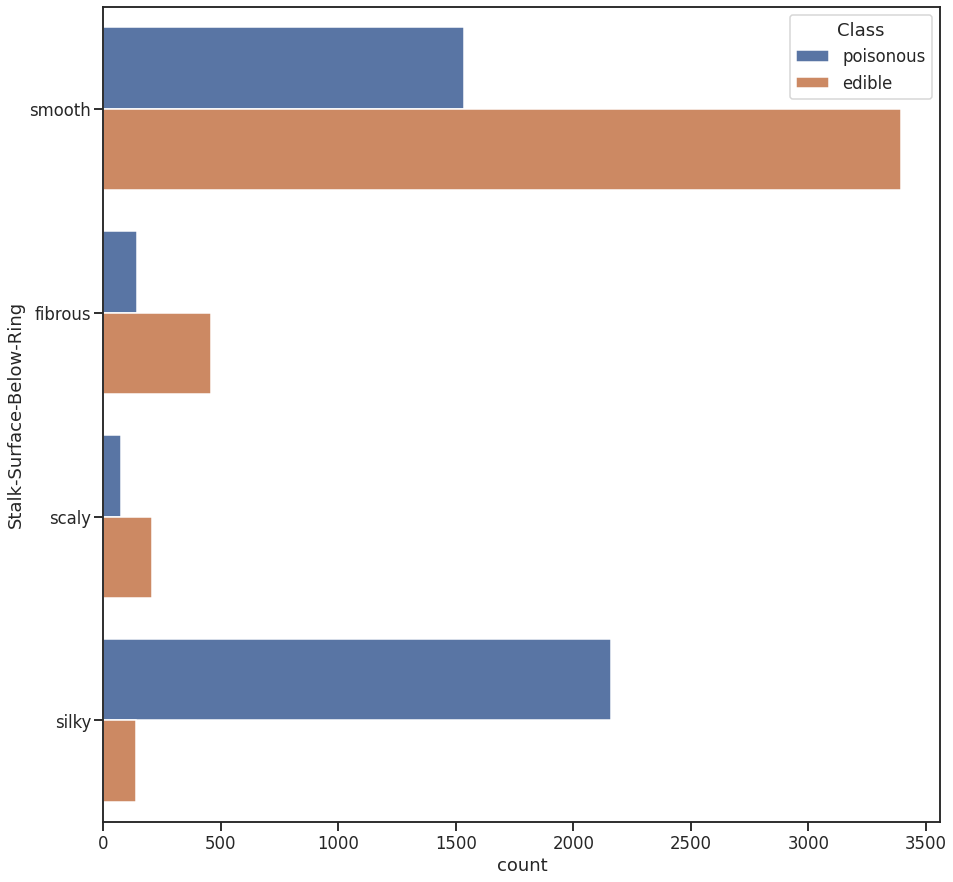

In [44]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Stalk-Surface-Below-Ring', hue='Class')
# plt.title("Beware Of Chocolate, White, Green (Spore Prints)")

<AxesSubplot:xlabel='count', ylabel='Stalk-Color-Above-Ring'>

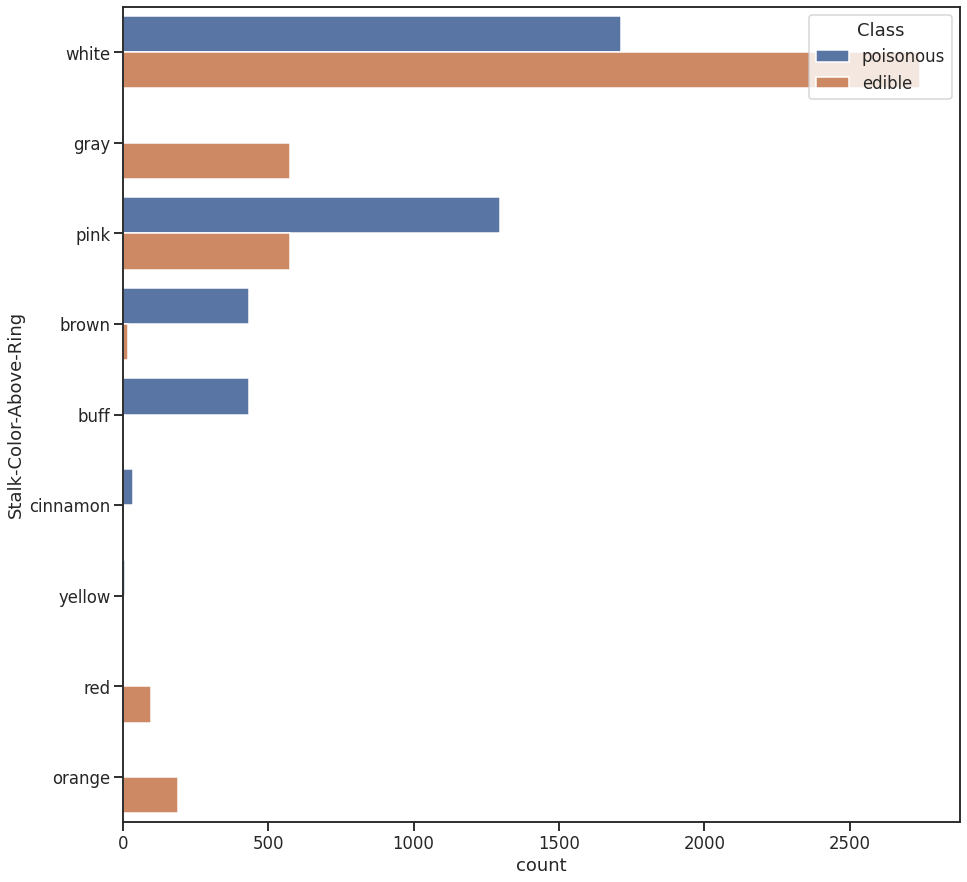

In [45]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Stalk-Color-Above-Ring', hue='Class')
# plt.title("Beware Of Chocolate, White, Green (Spore Prints)")

<AxesSubplot:xlabel='count', ylabel='Stalk-Color-Below-Ring'>

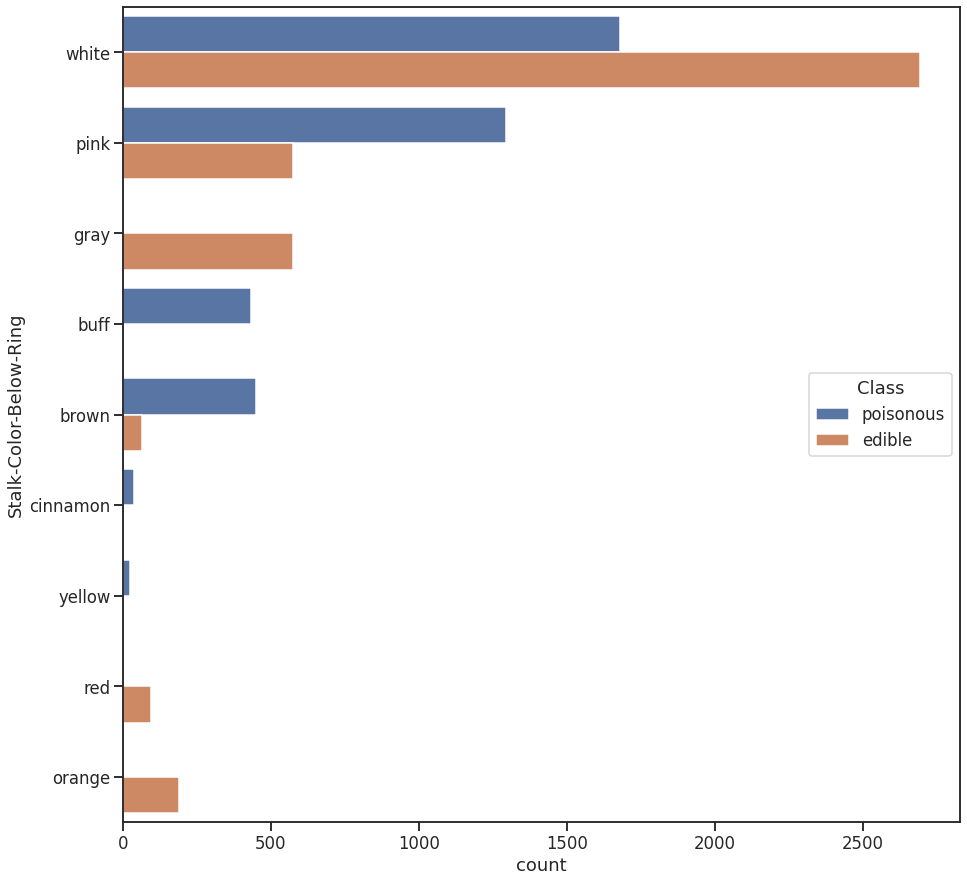

In [46]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Stalk-Color-Below-Ring', hue='Class')
# plt.title("Beware Of Chocolate, White, Green (Spore Prints)")


<AxesSubplot:xlabel='count', ylabel='Habitat'>

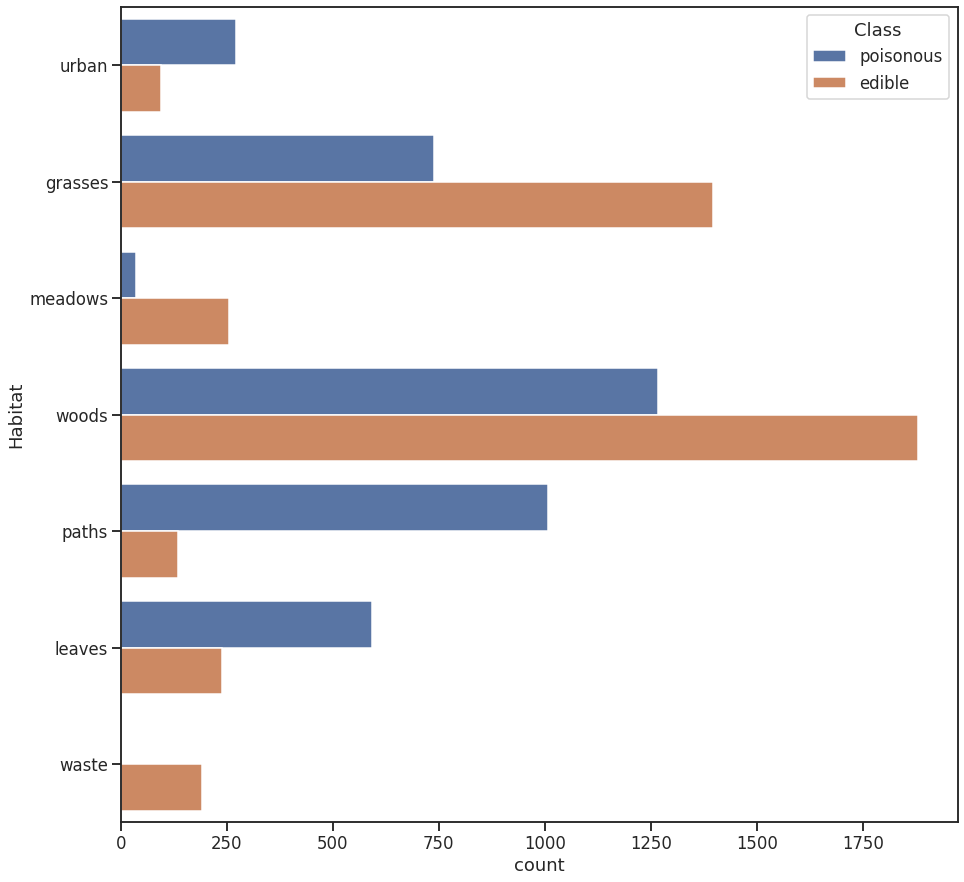

In [47]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Habitat', hue='Class')
# plt.title("Beware Of Chocolate, White, Green (Spore Prints)")

<AxesSubplot:xlabel='count', ylabel='Cap-Shape'>

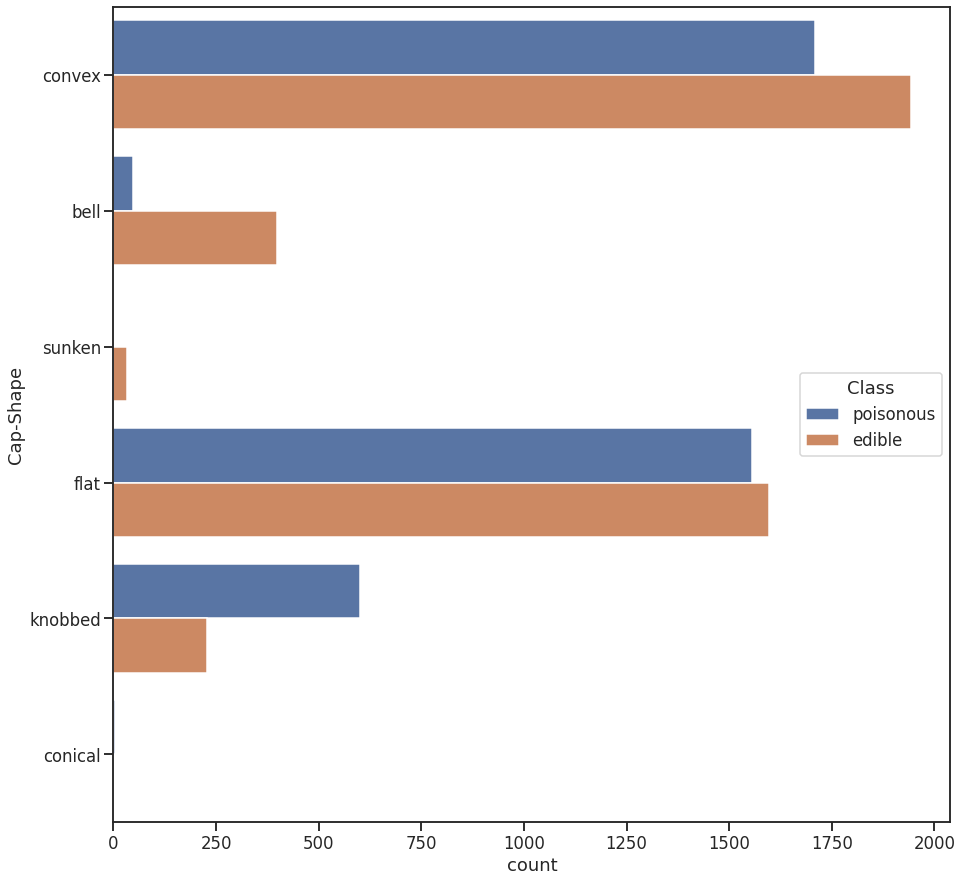

In [48]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Cap-Shape', hue='Class')
# plt.title("Beware Of Chocolate, White, Green (Spore Prints)")


<AxesSubplot:xlabel='count', ylabel='Cap-Color'>

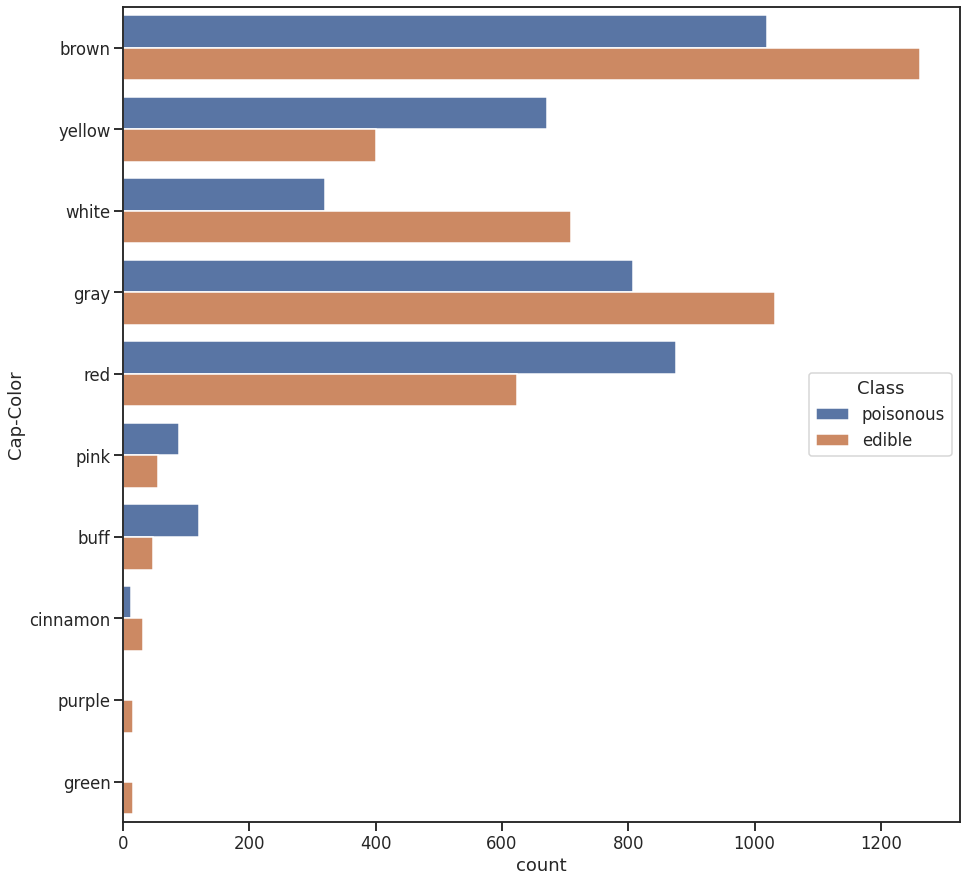

In [49]:
plt.figure(figsize=(15,15))
sns.countplot(data=mushroom, y='Cap-Color', hue='Class')
# plt.title("Beware Of Chocolate, White, Green (Spore Prints)")

## Evaluation

From seeing the difference in association strengths, I think it makes most sense
that weak associations show some variability, whereas stronger associations show more immediate and cold cut
variance (lowest variance); which makes some sense

* need to go back and add some interpretation for graphs